In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Fri Sep 26 10:39:02 PDT 2025
lutzes
/mnt/share/homes/lutzes/vivarium_research_alzheimers/verification_and_validation


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [2]:
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [3]:
locations = [
            'united_states_of_america',
            #  'brazil',
            #  'china',
            #  'germany',
            #  'israel',
            #  'japan',
            #  'spain',
            #  'sweden',
            #  'taiwan_(province_of_china)',
            #  'united_kingdom',
            ]



results_dirs = [
    'results/model5.0/model_spec/2025_09_25_09_02_38/results/',
]

artifact_dirs = ['artifacts/model5.0/' + x + '.hdf' for x in locations]
artifact_dirs

['artifacts/model5.0/united_states_of_america.hdf']

In [4]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['deaths.parquet',
 'ylls.parquet',
 'new_simulants.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'ylds.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet']

In [5]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end

# tweak final row to be named age group 95_plus
assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
age_dictionary.loc[13, 'age_group'] = '95_plus'

age_dictionary.tail()

,age_group_id,age_group_name,age_group,age_start,age_end
9,20,75 to 79,75_to_79,75.0,80.0
10,30,80 to 84,80_to_84,80.0,85.0
11,31,85 to 89,85_to_89,85.0,90.0
12,32,90 to 94,90_to_94,90.0,95.0
13,33,95 to 99,95_plus,95.0,125.0


## Verify that all simulants in the model have AD 

In [6]:
test = pd.read_parquet(results_dirs[0] + 'deaths' + '.parquet', filters=[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_dirs[0])])
test['location'] = locations[0]
test.artifact_path.unique()

array(['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model5.0/united_states_of_america.hdf'],
      dtype=object)

In [7]:
def load_df(measure):
    data = pd.DataFrame()
    data_all = pd.read_parquet(results_dirs[0] + measure + '.parquet', filters=[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_dirs[0])])
    for artifact in data_all.artifact_path.unique():
        temp = data_all[data_all.artifact_path == artifact]

        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols)['value'].sum().reset_index()
        
        temp['location'] = locations[0]
        # temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['current_year'] = temp['current_year'].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [67]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time
person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [9]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [10]:
person_time.groupby('sub_entity').value.sum()

sub_entity
alzheimers_blood_based_biomarker_state        1.368546e+08
alzheimers_disease_state                      1.524054e+08
alzheimers_mild_cognitive_impairment_state    7.242251e+07
Name: value, dtype: float64

In [11]:
person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()

sub_entity                                       alzheimers_blood_based_biomarker_state  \
location                 current_year age_group                                           
united_states_of_america 2025         25_to_29                                 3.507187   
                                      30_to_34                              1738.061602   
                                      35_to_39                              1923.942505   
                                      40_to_44                              1836.763860   
                                      45_to_49                              5557.388090   
...                                                                                 ...   
                         2100         75_to_79                            348738.628337   
                                      80_to_84                            412105.478439   
                                      85_to_89                            372248.804928   
                                      90_to_94                            186205.568789   
                                      95_plus                              50102.168378   

sub_entity                                       alzheimers_disease_state  \
location                 current_year age_group                             
united_states_of_america 2025         25_to_29                   0.000000   
                                      30_to_34                  72.648871   
                                      35_to_39                  85.675565   
                                      40_to_44                  63.129363   
                                      45_to_49                 202.414784   
...                                                                   ...   
                         2100         75_to_79              352624.090349   
                                      80_to_84              499480.525667   
                                      85_to_89              524914.143737   
                                      90_to_94              338554.258727   
                                      95_plus               125784.755647   

sub_entity                                       alzheimers_mild_cognitive_impairment_state  
location                 current_year age_group                                              
united_states_of_america 2025         25_to_29                                     1.503080  
                                      30_to_34                                   986.521561  
                                      35_to_39                                  1127.310062  
                                      40_to_44                                  1148.353183  
                                      45_to_49                                  3277.215606  
...                                                                                     ...  
                         2100         75_to_79                                182783.556468  
                                      80_to_84                                217053.782341  
                                      85_to_89                                198014.767967  
                                      90_to_94                                 99273.930185  
                                      95_plus                                  29774.012320  

[1140 rows x 3 columns]

In [12]:
#assert np.all(person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [13]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [14]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [15]:
# assert np.all(trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [16]:
out_counts = trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_counts.columns = [c.split('_to_')[0] for c in out_counts.columns]
#out_counts

In [17]:
out_rates = out_counts / person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()
#out_rates['alzheimers_blood_based_biomarker_state'].unstack()

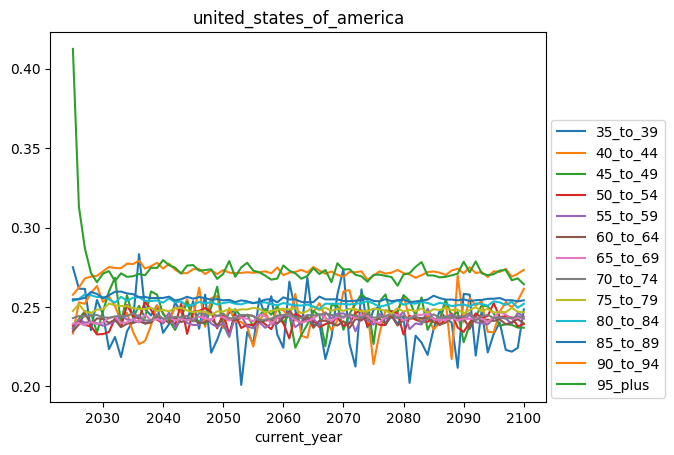

In [18]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:,2:].plot()
    plt.title(location)
    plt.legend(loc=(1.01, .01))

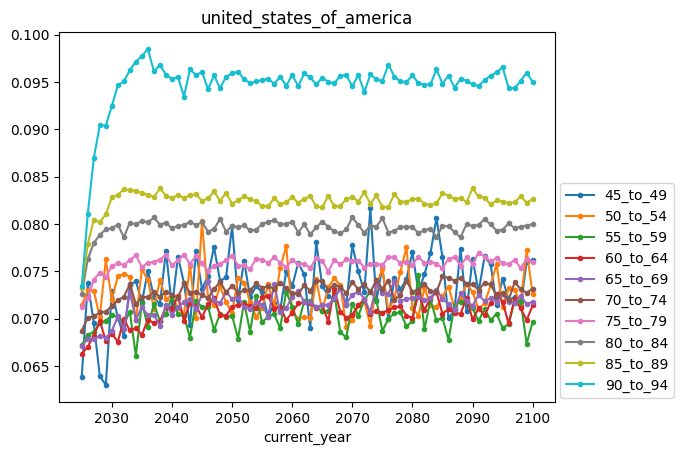

In [19]:
t = out_rates['alzheimers_blood_based_biomarker_state'].unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:,4:14].plot(marker='.')
    plt.title(location)
    plt.legend(loc=(1.01, .01))

In [20]:
# prevalence \approx incidence * duration
prevalence_count = person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()

mci_duration_est = (
    prevalence_count['alzheimers_mild_cognitive_impairment_state']
    / out_counts['alzheimers_blood_based_biomarker_state']
)
#mci_duration_est

In [21]:
new_sims = load_df('new_simulants').groupby(['location', 'current_year', 'age_group', ]).value.sum()
# new_sims


bbbm_duration_est = (
    prevalence_count['alzheimers_blood_based_biomarker_state']
    / new_sims
)
#bbbm_duration_est

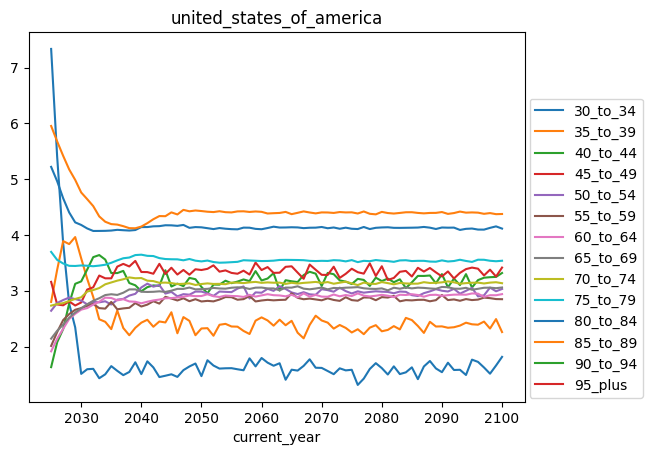

In [22]:
t = bbbm_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot()
    plt.title(location)
    plt.legend(loc=(1.01, .01))

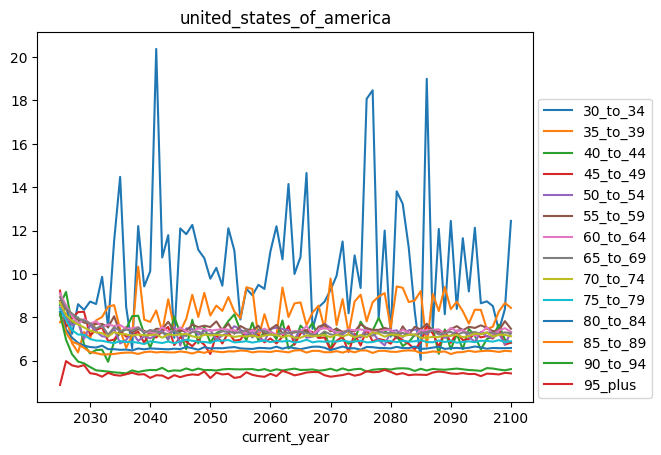

In [23]:
t = mci_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot()
    plt.title(location)
    plt.legend(loc=(1.01, .01))

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [24]:
%%time

cols = ['input_draw','current_year','location','age_group','sex']

def calculate_ocmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id'].isin(age_group_ids)]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

CPU times: user 33 s, sys: 5.16 s, total: 38.2 s
Wall time: 32 s


In [25]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)]
    art_ocmr = pd.concat([art_ocmr, data4])
#art_ocmr

In [26]:
art_data = art_ocmr
# location = 'United_States_Of_America'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [27]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030,2040,2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f'C{j}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.current_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                ax[i].fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                ax[i].plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(.5, .95, f"{year}", va='top', ha='center', transform=ax[i].transAxes)
#                 ax[i].tick_params(axis='x', labelrotation=90)
                
                if i == 2:
                    ax[i].set_xlabel("Age Group")
                    
                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
#                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)


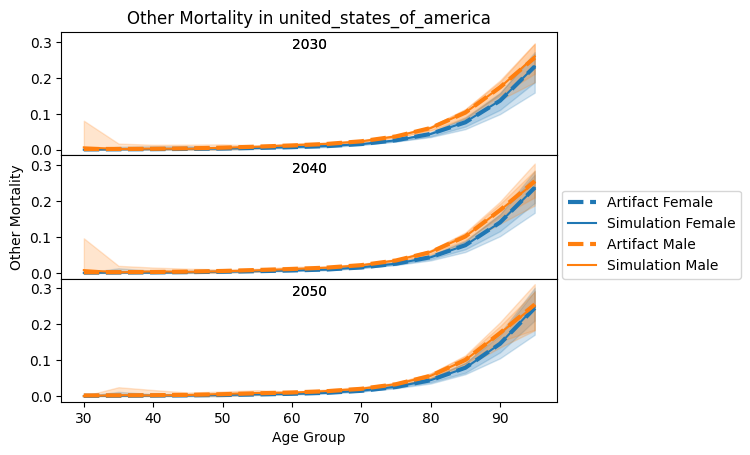

In [28]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [29]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.current_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

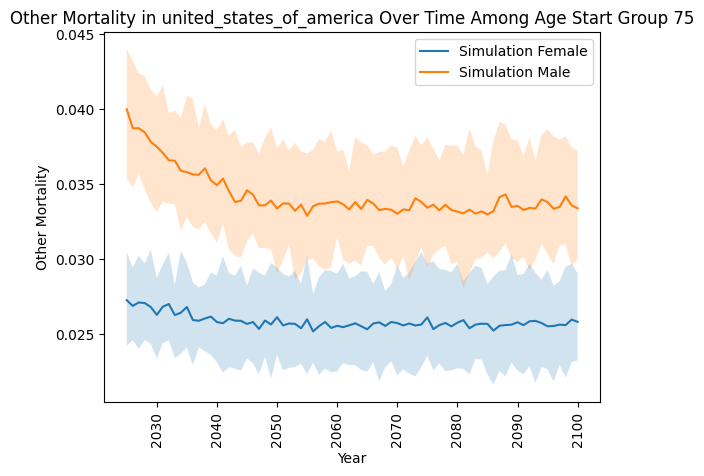

<Figure size 640x480 with 0 Axes>

In [30]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [31]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_emr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[
        person_time_total.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(infected) > 0

    deaths0 = load_df('deaths')
    deaths = deaths0.loc[
        deaths0.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr()

In [32]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)]
        out = pd.concat([out, data])
    return out

In [33]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
# art_emr

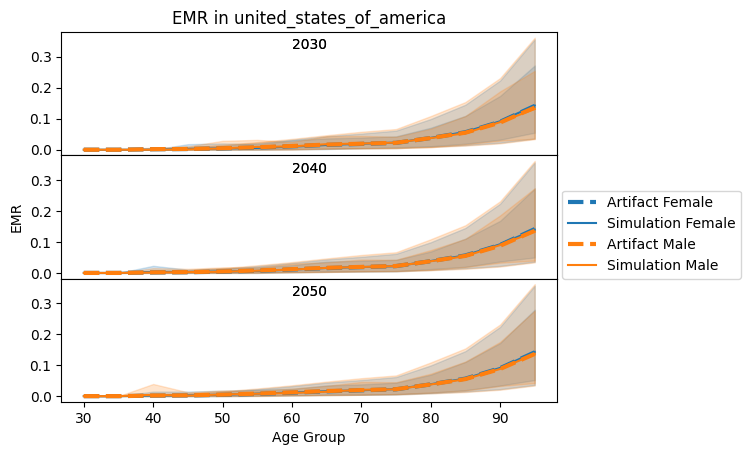

In [34]:
age_group_plot('EMR', sim_emr, art_emr, art_year=2021)

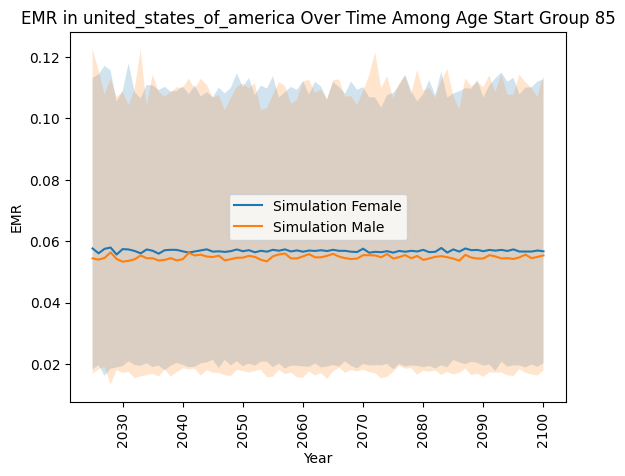

<Figure size 640x480 with 0 Axes>

In [35]:
over_time_plot('EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [52]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    # df['location'] = df.location.str.replace(' ', '_').str.lower()
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
art_incidence_data.tail()
    

draw_0  \
sex  age_start age_end location                 year_start year_end                 
Male 95.0      125.0   United States of America 2046       2047      10546.549825   
                                                2047       2048      10813.380822   
                                                2048       2049      11090.191756   
                                                2049       2050      11365.186769   
                                                2050       2051      11620.493269   

                                                                           draw_1  \
sex  age_start age_end location                 year_start year_end                 
Male 95.0      125.0   United States of America 2046       2047      10216.948418   
                                                2047       2048      10512.051381   
                                                2048       2049      10827.213359   
                                                2049       2050      11138.174690   
                                                2050       2051      11417.515932   

                                                                          draw_2  \
sex  age_start age_end location                 year_start year_end                
Male 95.0      125.0   United States of America 2046       2047      7910.522723   
                                                2047       2048      8130.611817   
                                                2048       2049      8358.854424   
                                                2049       2050      8583.196759   
                                                2050       2051      8793.232171   

                                                                           draw_3  \
sex  age_start age_end location                 year_start year_end                 
Male 95.0      125.0   United States of America 2046       2047      12084.221967   
                                                2047       2048      12489.675061   
                                                2048       2049      12919.955031   
                                                2049       2050      13344.844961   
                                                2050       2051      13744.105189   

                                                                          draw_4  \
sex  age_start age_end location                 year_start year_end                
Male 95.0      125.0   United States of America 2046       2047      7349.129966   
                                                2047       2048      7490.310322   
                                                2048       2049      7633.597729   
                                                2049       2050      7768.884684   
                                                2050       2051      7881.931278   

                                                                           draw_5  \
sex  age_start age_end location                 year_start year_end                 
Male 95.0      125.0   United States of America 2046       2047      10743.548534   
                                                2047       2048      11113.982782   
                                                2048       2049      11489.685650   
                                                2049       2050      11862.807336   
                                                2050       2051      12229.766694   

                                                                          draw_6  \
sex  age_start age_end location                 year_start year_end                
Male 95.0      125.0   United States of America 2046       2047      8095.587555   
                                                2047       2048      8364.685614   
                                                2048       2049      8646.514898   
                                                2049       2050      8918.936539   
         

In [77]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.lower()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2023"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean
    
    ratio = 100_000 / prev
    print(ratio)

    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'current_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
#scale

0.018283685923580616


In [78]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
united_states_of_america,168.0,0.003657,6.943028e-19,0.003657,0.003657,0.003657,0.003657,0.003657


In [70]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('new_simulants')
new_sims.head()

,age_group,current_year,sex,artifact_path,input_draw_number,scenario,input_draw,value,location
0,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,2,baseline,2,1.0,united_states_of_america
1,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,2,baseline,13,0.0,united_states_of_america
2,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,2,baseline,24,0.0,united_states_of_america
3,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,2,baseline,41,0.0,united_states_of_america
4,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,2,baseline,46,0.0,united_states_of_america


In [71]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state']

In [72]:
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','current_year']])

In [42]:
#new_ad_dementia

In [73]:
new_sims['total_incidence'] = new_sims['value'] / new_sims['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_sims['ratio']

def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims)

In [74]:
new_ad_dementia_summary = summarize(new_ad_dementia)
#new_ad_dementia_summary

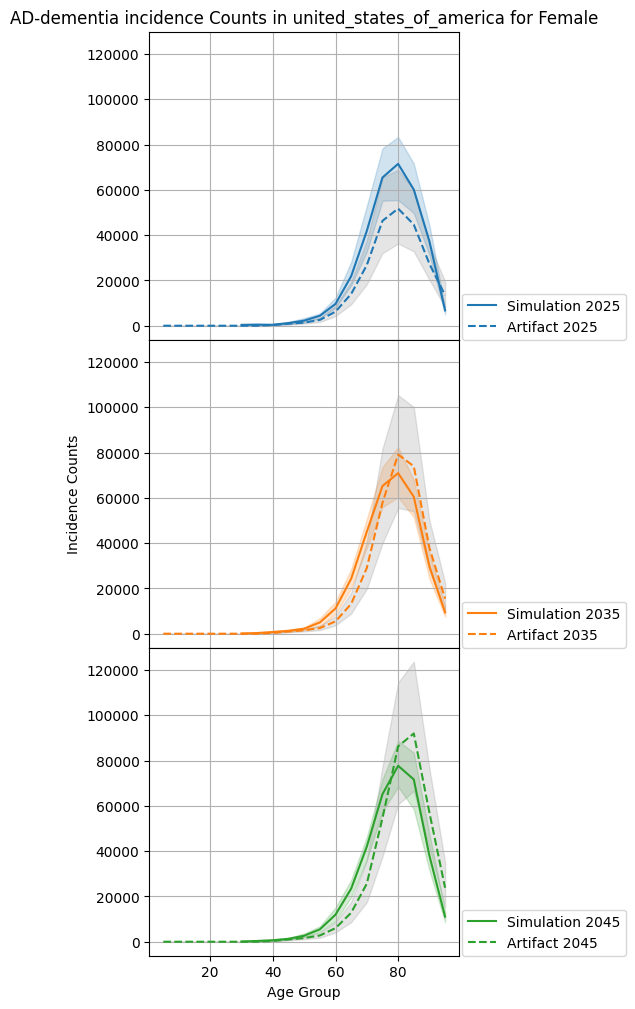

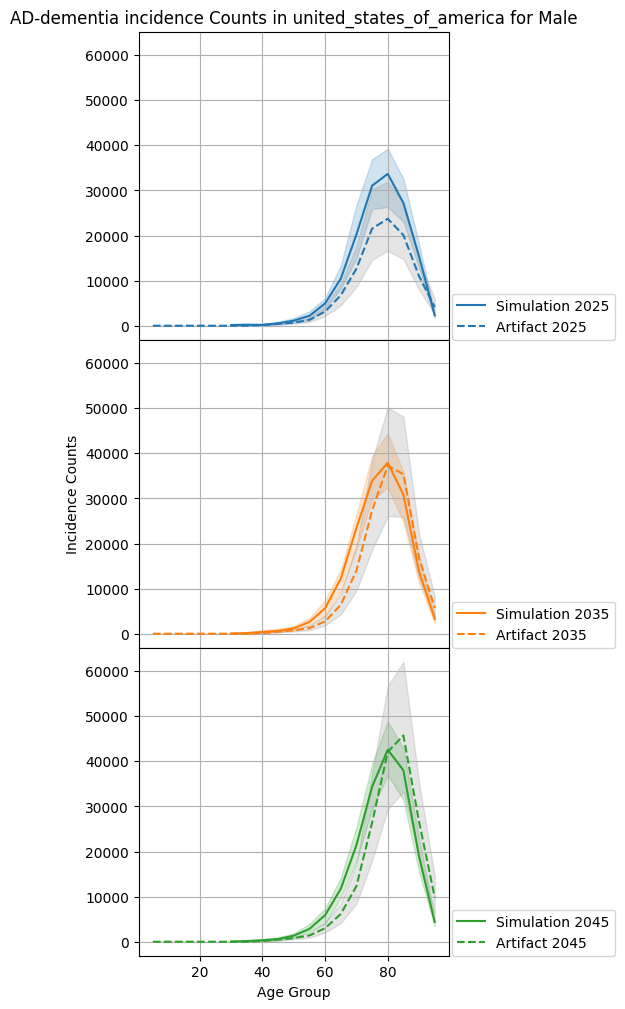

In [75]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4,12))
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query('location == @location and current_year == @year and sex == @sex')

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            ax[i].fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color='grey')
            ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)
            ax[i].plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            ax[i].grid(True)
            if i == 0:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
#             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 1:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend(loc=(1.01, 0))


I did some manual checks against GBD compare to make sure these were less than those, with the expectation they are about half. 

## Verifying Prevalence

In [85]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers.prevalence'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data.head()

draw_0  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_1  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_2  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_3  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_4  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_5  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_6  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_7  \
sex    age_sta

In [80]:
new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [91]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.loc[new_sims.sub_entity == 'alzheimers_disease_state']
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
723,2048,united_states_of_america,95_plus,Male,25.0,65119.243441,22950.990254,33705.612547,35629.298727,63026.755170,106624.827985,113612.576928,33,95 to 99,95.0,125.0
724,2049,united_states_of_america,95_plus,Female,25.0,169886.152295,57167.451605,76344.582566,82033.432294,176858.555593,254156.760368,258546.710881,33,95 to 99,95.0,125.0
725,2049,united_states_of_america,95_plus,Male,25.0,67008.949979,23766.729530,35267.579958,36122.551593,65273.796006,109967.986302,117120.152867,33,95 to 99,95.0,125.0
726,2050,united_states_of_america,95_plus,Female,25.0,173296.173779,58838.674910,76755.626622,84121.536096,180804.578526,258820.740251,266219.533249,33,95 to 99,95.0,125.0
727,2050,united_states_of_america,95_plus,Male,25.0,68689.298078,24799.125441,35980.056321,36292.449803,65794.451810,113344.028145,120627.728807,33,95 to 99,95.0,125.0


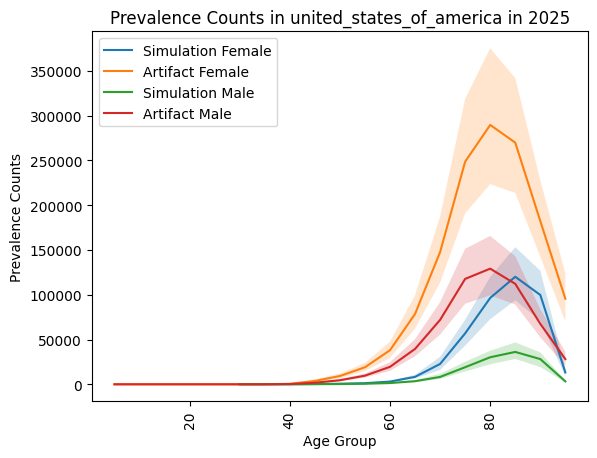

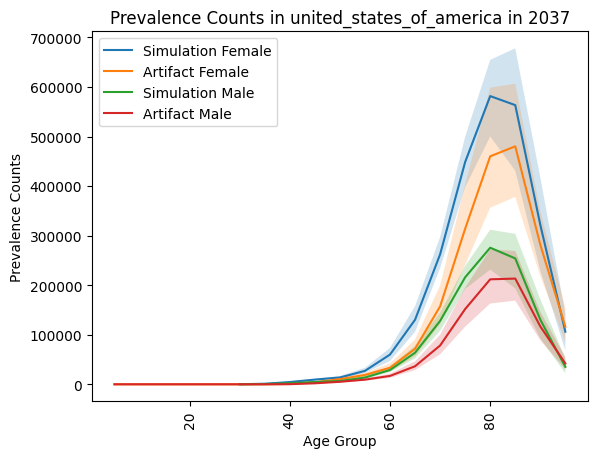

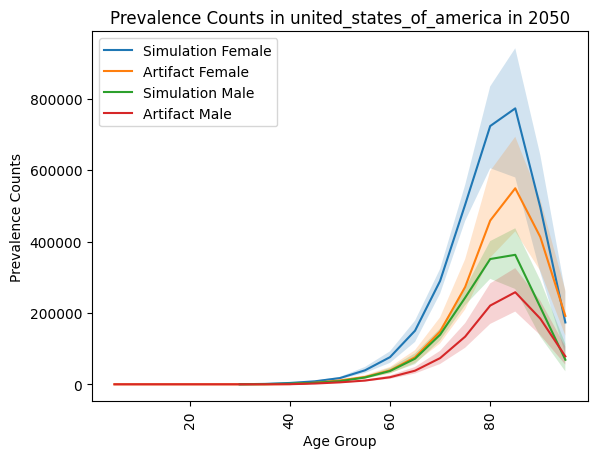

<Figure size 640x480 with 0 Axes>

In [92]:
for location in new_sims.location.unique():
    for year in [2025,2037,2050]:
        for sex in new_sims.sex.unique(): # [:1]:
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time

In [49]:
cols = ['input_draw','current_year','location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total.head()

,current_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,united_states_of_america,25.0,102057.233676,135.583353,101778.562628,101848.906776,102040.098563,102257.644353,102296.123203
1,2026,united_states_of_america,25.0,109332.962957,651.493176,108180.180698,108228.880493,109315.006160,110324.975770,110554.045175
2,2027,united_states_of_america,25.0,116234.605667,1223.429131,113913.930185,113955.715811,116282.283368,117973.348665,118198.209446
3,2028,united_states_of_america,25.0,122907.700041,1897.827329,119414.702259,119459.494045,123171.400411,125734.953593,125877.445585
4,2029,united_states_of_america,25.0,129357.156140,2627.632032,124639.909651,124668.167556,130106.611910,133129.406160,133271.597536


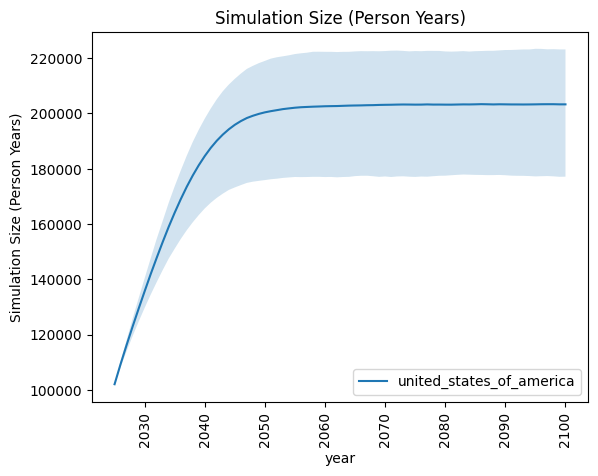

In [50]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.current_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()